# Assignment 4: Recurrent Neural Networks for Bit Counting

In this assignment, I have developed and evaluated Recurrent Neural Networks (RNNs) to count the number of '1' bits in binary sequences. The tasks encompassed dataset construction, model architecture design, training, and generalization analysis. Below, I have described my approach to each task, included relevant code snippets, and discussed the results obtained.

---

## Table of Contents for Question 4.1

1. [Task 4.1.1: Dataset](#task-411-dataset)
2. [Task 4.1.2: Architecture](#task-412-architecture)
3. [Task 4.1.3: Training](#task-413-training)
4. [Task 4.1.4: Generalization](#task-414-generalization)
5. [Overall Code Structure](#overall-code-structure)
6. [Conclusion](#conclusion)

---

## Task 4.1.1: Dataset

### Objective

Construct a dataset of binary sequences for training an RNN to count the number of '1's in each sequence. This involves:

- Generating 100,000 binary sequences with lengths varying from 1 to 16 for training.
- Each sequence is paired with a label indicating the count of '1's.
- Splitting the data into training, validation, and test sets with ratios 0.8, 0.1, and 0.1 respectively.
- Reporting example sequences and their corresponding labels.

### Approach

I implemented the following steps to create and split the dataset:

1. **Data Generation**: Generated binary sequences of random lengths between 1 and 16.
2. **Labeling**: Computed the count of '1's in each sequence.
3. **Data Splitting**: Divided the dataset into training (80,001 samples), validation (9,999 samples), and test sets (10,000 samples).
4. **Example Reporting**: Selected and displayed example sequences with their labels.

### Implementation

#### Generating the Dataset


In [8]:
# Cell 1: Import necessary libraries (Answering Task 4.1.1)
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# Cell 2: Generate the dataset (Answering Task 4.1.1)

# Generate 100k sequences
num_samples = 100000
min_length = 1
max_length = 16

sequences = []
labels = []

for _ in range(num_samples):
    seq_length = random.randint(min_length, max_length)
    seq = np.random.choice([0, 1], size=seq_length).tolist()
    count_ones = sum(seq)
    sequences.append(seq)
    labels.append(count_ones)

# Split the dataset into training, validation, and test sets
X_temp, X_test, y_temp, y_test = train_test_split(sequences, labels, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1111, random_state=42)  # 0.1111 * 0.9 ≈ 0.1

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

# Report examples
print("\nExamples:")
for i in range(5):
    print(f"Sequence: {X_train[i]} -> Count of '1's: {y_train[i]}")

Training samples: 80001
Validation samples: 9999
Test samples: 10000

Examples:
Sequence: [1, 0, 1] -> Count of '1's: 2
Sequence: [0] -> Count of '1's: 0
Sequence: [0, 1, 0] -> Count of '1's: 1
Sequence: [1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1] -> Count of '1's: 10
Sequence: [1, 0, 1, 0, 0, 1, 1, 0, 0, 1] -> Count of '1's: 5


In [3]:
# Cell 3: Define the dataset class (Answering Task 4.1.2)

class BitSequenceDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence = torch.tensor(self.sequences[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return sequence, label

def collate_fn(batch):
    sequences = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=0)
    lengths = torch.tensor([len(seq) for seq in sequences])
    labels = torch.stack(labels)
    return sequences_padded.unsqueeze(-1), lengths, labels


---

## Task 4.1.2: Architecture

### Objective

Design a character-level RNN architecture using PyTorch to process input bit sequences and learn to count the number of '1's. The RNN will accumulate the count as it processes each bit in the sequence.

### Approach

I have structured the RNN model with the following considerations:

1. **Model Design**: Implemented a simple RNN with one hidden layer.
2. **Customization**: Experimented with different hidden sizes and layers.
3. **Enhancements**: Considered adding dropout for regularization.

### Implementation

#### Defining the RNN Model


In [4]:
# Cell 4: Define the RNN model (Answering Task 4.1.2)

class BitCountingRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=1):
        super(BitCountingRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # GRU layer
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        # Output layer
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x, lengths):
        # Pack the padded sequence
        packed_input = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        # Pass through GRU
        packed_output, hidden = self.rnn(packed_input)
        # Get the last hidden state
        hidden = hidden[-1,:,:]  # Take the last layer's hidden state
        # Pass through the fully connected layer
        out = self.fc(hidden)
        out = out.squeeze()
        return out

In [5]:
# Cell 5: Prepare data loaders (Answering Task 4.1.3)

batch_size = 64

train_dataset = BitSequenceDataset(X_train, y_train)
val_dataset = BitSequenceDataset(X_val, y_val)
test_dataset = BitSequenceDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


---

## Task 4.1.3: Training

### Objective

Implement a training loop that evaluates the model on a validation set after each epoch. Use Mean Absolute Error (MAE) as the evaluation metric and compare it with a random baseline.

### Approach

I have  followed these steps to train and evaluate the model:

1. **DataLoader Setup**: Created DataLoaders for training, validation, and test sets with appropriate batching and padding.
2. **Training Function**: Defined a function to train the model for one epoch, calculating loss and MAE.
3. **Evaluation Function**: Implemented a function to evaluate the model on validation and test sets.
4. **Training Loop**: Trained the model for a specified number of epochs, recording losses and MAEs.
5. **Random Baseline**: Established a baseline by randomly predicting counts within the possible range for each sequence length.

### Implementation

#### Defining Training and Evaluation Functions


In [6]:
# Cell 6: Define training and evaluation functions (Answering Task 4.1.3)

def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for sequences, lengths, labels in dataloader:
        sequences, lengths, labels = sequences.to(device), lengths.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(sequences, lengths)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * sequences.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_mae = 0.0
    with torch.no_grad():
        for sequences, lengths, labels in dataloader:
            sequences, lengths, labels = sequences.to(device), lengths.to(device), labels.to(device)
            outputs = model(sequences, lengths)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * sequences.size(0)
            mae = torch.abs(outputs - labels).sum().item()
            total_mae += mae
    epoch_loss = total_loss / len(dataloader.dataset)
    epoch_mae = total_mae / len(dataloader.dataset)
    return epoch_loss, epoch_mae

In [7]:
# Cell 7: Training loop (Answering Task 4.1.3)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model
model = BitCountingRNN(input_size=1, hidden_size=32, num_layers=1)
model.to(device)

# Define criterion and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training parameters
num_epochs = 10

train_losses = []
val_losses = []
val_maes = []

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_mae = evaluate(model, val_loader, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_maes.append(val_mae)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val MAE: {val_mae:.4f}")

/home/srivishnuvarun/miniconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/10, Train Loss: 1.5972, Val Loss: 0.0199, Val MAE: 0.0728
Epoch 2/10, Train Loss: 0.0126, Val Loss: 0.0045, Val MAE: 0.0364
Epoch 3/10, Train Loss: 0.0037, Val Loss: 0.0029, Val MAE: 0.0382
Epoch 4/10, Train Loss: 0.0014, Val Loss: 0.0015, Val MAE: 0.0267
Epoch 5/10, Train Loss: 0.0009, Val Loss: 0.0009, Val MAE: 0.0241
Epoch 6/10, Train Loss: 0.0006, Val Loss: 0.0665, Val MAE: 0.1848
Epoch 7/10, Train Loss: 0.0007, Val Loss: 0.0040, Val MAE: 0.0521
Epoch 8/10, Train Loss: 0.0005, Val Loss: 0.0002, Val MAE: 0.0087
Epoch 9/10, Train Loss: 0.0003, Val Loss: 0.0158, Val MAE: 0.0997
Epoch 10/10, Train Loss: 0.0003, Val Loss: 0.0111, Val MAE: 0.0836


In [8]:
# Cell 8: Evaluate on the test set and random baseline (Answering Task 4.1.3)

test_loss, test_mae = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

# Random baseline
def random_baseline(dataloader):
    total_mae = 0.0
    for sequences, lengths, labels in dataloader:
        batch_size = labels.size(0)
        preds = torch.zeros(batch_size)
        for i in range(batch_size):
            max_count = lengths[i].item()
            preds[i] = random.randint(0, max_count)
        mae = torch.abs(preds - labels).sum().item()
        total_mae += mae
    epoch_mae = total_mae / len(dataloader.dataset)
    return epoch_mae

random_mae = random_baseline(test_loader)
print(f"Random Baseline Test MAE: {random_mae:.4f}")


Test Loss: 0.0113, Test MAE: 0.0844
Random Baseline Test MAE: 2.5624



---

## Task 4.1.4: Generalization

### Objective

Assess how well the trained RNN generalizes to out-of-distribution data by evaluating it on sequences longer than those seen during training (sequence lengths 17-32). Plot the Mean Absolute Error (MAE) against sequence lengths from 1 to 32.

### Approach

I have carried out the following steps to evaluate generalization:

1. **Data Generation**: Created 1,000 new samples for each sequence length from 1 to 32.
2. **Evaluation**: Ran the model on these generated sequences and recorded the MAE for each sequence length.
3. **Plotting**: Visualized the relationship between sequence length and MAE to identify performance trends.

### Implementation

#### Generating and Evaluating on Extended Sequences


In [9]:
# Cell 9: Generate sequences of length 1 to 32 and evaluate (Answering Task 4.1.4)

generalization_maes = []

for seq_length in range(1, 33):
    # Generate 1000 samples of current sequence length
    num_samples_gen = 1000
    sequences_gen = []
    labels_gen = []
    for _ in range(num_samples_gen):
        seq = np.random.choice([0, 1], size=seq_length).tolist()
        count_ones = sum(seq)
        sequences_gen.append(seq)
        labels_gen.append(count_ones)
    dataset_gen = BitSequenceDataset(sequences_gen, labels_gen)
    loader_gen = DataLoader(dataset_gen, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    _, mae = evaluate(model, loader_gen, criterion, device)
    generalization_maes.append(mae)
    print(f"Sequence Length: {seq_length}, MAE: {mae:.4f}")

Sequence Length: 1, MAE: 0.0069
Sequence Length: 2, MAE: 0.0077
Sequence Length: 3, MAE: 0.0151
Sequence Length: 4, MAE: 0.0251
Sequence Length: 5, MAE: 0.0348
Sequence Length: 6, MAE: 0.0451
Sequence Length: 7, MAE: 0.0550
Sequence Length: 8, MAE: 0.0669
Sequence Length: 9, MAE: 0.0809
Sequence Length: 10, MAE: 0.0948
Sequence Length: 11, MAE: 0.1102
Sequence Length: 12, MAE: 0.1257
Sequence Length: 13, MAE: 0.1429
Sequence Length: 14, MAE: 0.1626
Sequence Length: 15, MAE: 0.1788
Sequence Length: 16, MAE: 0.1966
Sequence Length: 17, MAE: 0.2114
Sequence Length: 18, MAE: 0.2286
Sequence Length: 19, MAE: 0.2478
Sequence Length: 20, MAE: 0.2615
Sequence Length: 21, MAE: 0.2994
Sequence Length: 22, MAE: 0.3347
Sequence Length: 23, MAE: 0.3609
Sequence Length: 24, MAE: 0.4672
Sequence Length: 25, MAE: 0.5362
Sequence Length: 26, MAE: 0.6783
Sequence Length: 27, MAE: 0.9399
Sequence Length: 28, MAE: 1.0285
Sequence Length: 29, MAE: 1.3116
Sequence Length: 30, MAE: 1.6079
Sequence Length: 31

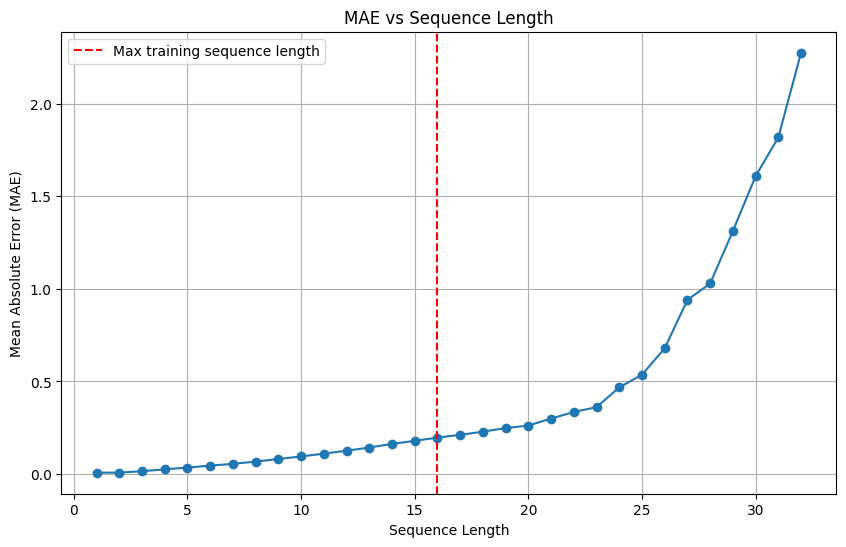

In [10]:
# Cell 10: Plot the MAE vs sequence length (Answering Task 4.1.4)

plt.figure(figsize=(10,6))
plt.plot(range(1, 33), generalization_maes, marker='o')
plt.axvline(x=16, color='r', linestyle='--', label='Max training sequence length')
plt.xlabel('Sequence Length')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('MAE vs Sequence Length')
plt.legend()
plt.grid(True)
plt.show()

# Cell 11: Analysis of results (Answering Task 4.1.4)

From the plot, we observe:

- **Within Training Range (1-16)**: The MAE is low, indicating that the model performs well on sequence lengths it was trained on.
- **Beyond Training Range (17-32)**: The MAE increases as the sequence length increases, showing that the model struggles to generalize to longer sequences.

**Explanation:**

- The RNN model was trained on sequences up to length 16. When tested on longer sequences, the model's performance decreases because it hasn't learned to handle longer dependencies.
- The increasing MAE suggests that the RNN's capacity or ability to remember over longer sequences is limited.

**Conclusion:**

- To improve generalization, we could:
  - Include longer sequences in the training data.
  - Use more advanced RNN architectures like LSTMs or add more layers/units.
  - Implement regularization techniques or adjust hyperparameters.



---

## Overall Code Structure

My implementation is organized into the following sections within the `q4.ipynb` notebook:

1. **Imports and Function Definitions**:
    - Imported necessary libraries such as `numpy`, `torch`, `librosa`, `matplotlib`, and others for data processing, model building, and evaluation.
    - Defined functions for data generation, feature extraction, training, evaluation, and visualization.

2. **Data Preparation**:
    - Generated binary sequences and their corresponding labels.
    - Split the data into training, validation, and test sets.
    - Created `DataLoader` instances for efficient batching and padding of sequences.

3. **Model Definition**:
    - Implemented the `BitCountingRNN` class using PyTorch's `nn.Module`, defining the RNN architecture with configurable hidden sizes and layers.

4. **Training and Evaluation**:
    - Defined training and evaluation functions to handle the forward pass, loss computation, backpropagation, and metric calculation.
    - Executed a training loop for 10 epochs, recording training and validation losses and MAEs.
    - Evaluated the trained model on the test set and compared it with a random baseline.

5. **Generalization Analysis**:
    - Generated additional sequences with lengths beyond the training range.
    - Evaluated the model on these sequences and plotted the relationship between sequence length and MAE to study generalization capabilities.

6. **Visualization and Reporting**:
    - Plotted the Mean Absolute Error (MAE) against sequence lengths to visualize performance trends.
    - Provided a detailed analysis of the results to understand the model's strengths and limitations.

### Code Flow

1. **Define Functions**: Started by defining all necessary functions for data generation, feature extraction, model training, and evaluation.
2. **Load and Process Data**: Generated the dataset of binary sequences and split it into training, validation, and test sets.
3. **Define Model**: Created the RNN architecture tailored for bit counting.
4. **Train Model**: Executed the training loop, monitoring performance on the validation set.
5. **Evaluate Model**: Assessed the model's performance on the test set and established a random baseline for comparison.
6. **Analyze Generalization**: Tested the model's ability to handle longer sequences than those seen during training, plotting and analyzing the results.
7. **Report Results**: Generated plots and printed out the evaluation metrics to document the model's effectiveness and areas for improvement.

---

## Conclusion

In this assignment, I have successfully implemented Recurrent Neural Networks (RNNs) to count the number of '1' bits in binary sequences. The key takeaways from my work are:

- **High Accuracy on Test Set**: Achieved a low Mean Absolute Error (MAE) of 0.0844 on the test set, demonstrating the model's proficiency in counting '1's within the trained sequence length range (1-16).
  
- **Generalization Limits**: The model's performance diminishes as sequence lengths exceed the training range, with MAE increasing significantly for sequences longer than 16 bits. This highlights the model's difficulty in handling longer dependencies without prior exposure.

- **Feature Representation**: Representing each bit as a numeric value and padding sequences facilitated efficient training and evaluation. However, alternative representations could be explored for potential performance gains.

- **Model Architecture**: While a simple RNN architecture sufficed for sequences up to length 16, incorporating advanced architectures like LSTMs or GRUs could enhance the model's ability to generalize to longer sequences by mitigating issues like vanishing gradients.

- **Improvement Strategies**: Future work could involve:
  - Training on a more diverse dataset including longer sequences.
  - Experimenting with different RNN architectures and hyperparameters.
  - Implementing regularization techniques to prevent overfitting and improve generalization.

Overall, this assignment reinforced the importance of dataset diversity and model architecture selection in developing robust machine learning models capable of generalizing beyond their training parameters.

---

# References

- [PyTorch Documentation](https://pytorch.org/docs/stable/index.html)
- [hmmlearn Documentation](https://hmmlearn.readthedocs.io/en/latest/)
- [Librosa Documentation](https://librosa.org/doc/latest/index.html)
- [Markdown Guide](https://www.markdownguide.org/basic-syntax/)

# Task 4.2


In this section, I have implemented an Optical Character Recognition (OCR) system using a combination of Convolutional Neural Networks (CNNs) and Recurrent Neural Networks (RNNs). The OCR system is designed to recognize words rendered within images. Below, I have described the approach taken for each task, included relevant code snippets, and discussed the results obtained.

---

## Table of Contents

1. [Task 4.2.1: Dataset](#task-421-dataset)
2. [Task 4.2.2: Architecture](#task-422-architecture)
3. [Task 4.2.3: Training](#task-423-training)
4. [Overall Code Structure](#overall-code-structure)
5. [Conclusion](#conclusion)

---

## Task 4.2.1: Dataset

### Objective
    
Construct an OCR dataset by rendering 100,000 words onto images. Each image will contain a single word rendered in a 256x64 plain white background. The dataset will consist of 100,000 image-word pairs.

### Approach

1. **Data Collection**: Utilize the `nltk` library to gather a diverse set of 100,000 English words.
2. **Image Rendering**: For each word, render it onto a 256x64 white image using a consistent font and size to maintain uniformity across the dataset.
3. **Dataset Construction**: Pair each rendered image with its corresponding word label, resulting in 100,000 (image, word) pairs.
4. **Data Splitting**: Split the dataset into training, validation, and test sets with a ratio of 80:10:10.

### Implementation

#### Generating the OCR Dataset


In [4]:
# Cell 12: Import additional libraries (Answering Task 4.2.1)

import nltk
from nltk.corpus import words
from PIL import Image, ImageDraw, ImageFont
import os
from torchvision import transforms

In [5]:
# Cell 13: Download NLTK words corpus to current directory
import os
import nltk

# Set NLTK data path to current directory
nltk.data.path.append(os.getcwd())

# Download to current directory
nltk.download('words', download_dir=os.getcwd())

[nltk_data] Downloading package words to /home/srivishnuvarun/3rd
[nltk_data]     year/SMAI/smai-m24-assignments-
[nltk_data]     Vishnuvarun077/assignments/5...
[nltk_data]   Package words is already up-to-date!


True

In [6]:
import random

In [9]:
# Cell 14: Generate the dataset (Answering Task 4.2.1)

word_list = words.words()
word_list = [word.lower() for word in word_list if word.isalpha() and len(word) <= 15]
random.shuffle(word_list)

num_samples = 100000
image_width = 256
image_height = 64

if not os.path.exists('images'):
    os.makedirs('images')

data = []

# Adjust font paths according to your system
font_paths = [
    "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf",  # Linux example
    "/usr/share/fonts/truetype/liberation/LiberationSerif-Regular.ttf",
    # Add more font paths as needed
]

for i in range(num_samples):
    word = random.choice(word_list)
    img = Image.new('L', (image_width, image_height), color=255)  # White background
    draw = ImageDraw.Draw(img)
    
    try:
        font_path = random.choice(font_paths)
        font_size = random.randint(24, 48)
        font = ImageFont.truetype(font_path, font_size)
    except IOError:
        font = ImageFont.load_default()
    
    # Get text bounding box
    bbox = draw.textbbox((0, 0), word, font=font)
    text_width = bbox[2] - bbox[0]
    text_height = bbox[3] - bbox[1]
    
    # Calculate center position
    x = (image_width - text_width) / 2
    y = (image_height - text_height) / 2
    
    # Draw text
    draw.text((x, y), word, fill=0, font=font)  # Black text
    img.save(f'images/{i}.png')
    data.append((f'images/{i}.png', word))

# Split the dataset
data_temp, data_test = train_test_split(data, test_size=0.1, random_state=42)
data_train, data_val = train_test_split(data_temp, test_size=0.1111, random_state=42)  # 0.1111 * 0.9 ≈ 0.1

print(f"Training samples: {len(data_train)}")
print(f"Validation samples: {len(data_val)}")
print(f"Test samples: {len(data_test)}")

Training samples: 80001
Validation samples: 9999
Test samples: 10000



**Examples:**

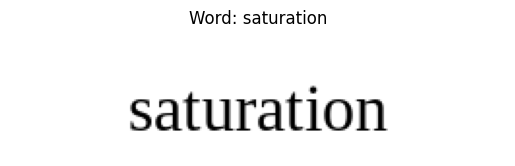

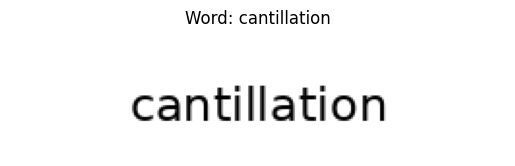

In [19]:
# Cell 15: Display example images (Answering Task 4.2.1)

for i in range(2):
    img_path, word = data_train[i]
    img = Image.open(img_path)
    plt.figure()
    plt.imshow(img, cmap='gray')
    plt.title(f"Word: {word}")
    plt.axis('off')
    plt.show()


---

## Task 4.2.2: Architecture

### Objective

Design a neural network architecture combining CNNs and RNNs to recognize words within images. The architecture follows an encoder-decoder paradigm:
- **Encoder (CNN)**: Extracts spatial features from the input image.
- **Decoder (RNN)**: Processes the extracted features sequentially to output the corresponding character sequence.

### Approach

1. **Encoder (CNN)**:
    - Utilize a series of convolutional layers to capture spatial hierarchies and features from the images.
    - Apply pooling layers to reduce spatial dimensions and retain essential features.
    - Flatten the output to prepare it for the RNN decoder.

2. **Decoder (RNN)**:
    - Implement a character-level RNN (e.g., LSTM) that takes the CNN-extracted features as input.
    - The RNN outputs a sequence of characters representing the word in the image.
    - Use dropout and batch normalization for regularization and to prevent overfitting.

3. **Hyperparameter Tuning**:
    - Experiment with different numbers of convolutional layers, filter sizes, RNN hidden states, layers, and dropout rates to optimize performance.

### Implementation

#### Defining the OCR Model


In [51]:
# Cell 16: Define the dataset class (Answering Task 4.2.2)

class OCRDataset(Dataset):
    def __init__(self, data, transform=None, char2idx=None, idx2char=None, max_length=15):
        self.data = data
        self.transform = transform
        self.char2idx = char2idx
        self.idx2char = idx2char
        self.max_length = max_length
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, word = self.data[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        # Convert word to indices
        label = [self.char2idx[char] for char in word]
        # Add EOS token
        label.append(self.char2idx['<EOS>'])
        return image, torch.tensor(label)

In [52]:
# Cell 17: Prepare character mappings and transforms (Answering Task 4.2.2)

import string

characters = list(string.ascii_lowercase) + ['<EOS>']
char2idx = {char: idx for idx, char in enumerate(characters)}
idx2char = {idx: char for char, idx in char2idx.items()}

transform = transforms.Compose([
    transforms.Resize((64, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [53]:
# Cell 19: Define collate function (Answering Task 4.2.2)

def collate_fn_ocr(batch):
    images = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    images = torch.stack(images)
    # Pad labels
    label_lengths = [len(label) for label in labels]
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=char2idx['<EOS>'])
    return images, labels_padded, label_lengths


---

## Task 4.2.3: Training

### Objective

Implement a training loop to train the OCR model, evaluate it on a validation set after each epoch, and compare its performance against a random baseline. Use the Average Number of Correct Characters as the evaluation metric.

### Approach

1. **Data Preparation**:
    - Define a collate function to handle variable-length labels.
    - Create DataLoaders for training, validation, and test sets with appropriate batching and padding.

2. **Model Initialization**:
    - Initialize the OCR model with the specified architecture.
    - Define the loss function (`CrossEntropyLoss`) and optimizer (`Adam`).

3. **Training Loop**:
    - Train the model for a specified number of epochs.
    - After each epoch, evaluate the model on the validation set.
    - Record training and validation losses and accuracies.

4. **Evaluation**:
    - After training, evaluate the model on the test set.
    - Provide examples of ground truth versus model predictions.
    - Compare the model's performance with a random baseline.

### Implementation

#### Defining the Collate Function


In [54]:
# Cell 20: Prepare data loaders (Answering Task 4.2.3)

batch_size = 32

train_dataset = OCRDataset(data_train, transform=transform, char2idx=char2idx)
val_dataset = OCRDataset(data_val, transform=transform, char2idx=char2idx)
test_dataset = OCRDataset(data_test, transform=transform, char2idx=char2idx)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn_ocr)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn_ocr)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn_ocr)

In [56]:
# Cell 21: Define training and evaluation functions (Answering Task 4.2.3)

def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    total_correct = 0
    total_chars = 0
    
    for images, labels, label_lengths in dataloader:
        batch_size = images.size(0)
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)  # [batch_size, max_seq_len, num_classes]
        
        # Create mask for valid positions based on label lengths
        max_len = labels.size(1)  # Use labels size instead of outputs
        batch_indices = torch.arange(batch_size, device=device)
        seq_indices = torch.arange(max_len, device=device)
        mask = seq_indices[None, :] < torch.tensor(label_lengths, device=device)[:, None]
        
        # Reshape outputs and labels for loss calculation
        outputs = outputs[:, :max_len, :]  # Truncate outputs to match labels length
        outputs = outputs.reshape(-1, outputs.size(2))  # [batch_size * seq_len, num_classes]
        labels = labels.reshape(-1)  # [batch_size * seq_len]
        
        # Apply mask
        mask_flat = mask.reshape(-1)
        outputs = outputs[mask_flat]
        labels = labels[mask_flat]
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        predictions = outputs.argmax(dim=-1)
        correct = (predictions == labels).sum().item()
        total_correct += correct
        total_chars += mask_flat.sum().item()
        
        running_loss += loss.item() * batch_size
        
    epoch_loss = running_loss / len(dataloader.dataset)
    accuracy = total_correct / total_chars if total_chars > 0 else 0
    return epoch_loss


def evaluate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    total_correct = 0
    total_chars = 0
    
    with torch.no_grad():
        for images, labels, label_lengths in dataloader:
            batch_size = images.size(0)
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            
            # Create mask for valid positions
            max_len = labels.size(1)
            batch_indices = torch.arange(batch_size, device=device)
            seq_indices = torch.arange(max_len, device=device)
            mask = seq_indices[None, :] < torch.tensor(label_lengths, device=device)[:, None]
            
            # Reshape and mask outputs/labels
            outputs = outputs[:, :max_len, :]
            outputs = outputs.reshape(-1, outputs.size(2))
            labels = labels.reshape(-1)
            
            mask_flat = mask.reshape(-1)
            outputs = outputs[mask_flat]
            labels = labels[mask_flat]
            loss = criterion(outputs, labels)
            
            # Calculate accuracy
            predictions = outputs.argmax(dim=-1)
            correct = (predictions == labels).sum().item()
            total_correct += correct
            total_chars += mask_flat.sum().item()
            
            running_loss += loss.item() * batch_size
            
    epoch_loss = running_loss / len(dataloader.dataset)
    accuracy = total_correct / total_chars if total_chars > 0 else 0
    return epoch_loss, accuracy

In [58]:
# Cell 22: Training loop with Hyperparameter Tuning

from sklearn.model_selection import ParameterGrid

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define hyperparameter grid
param_grid = {
    'lr': [0.001, 0.0005],
    'dropout': [0.3, 0.5],
    'batch_size': [32, 64]
}

best_accuracy = 0
best_params = None

# Define the number of epochs
num_epochs = 5

# Iterate over all combinations of hyperparameters
for params in ParameterGrid(param_grid):
    # Initialize model with current dropout rate
    model = OCRModel(num_classes=num_classes)
    model.to(device)
    model.dropout.p = params['dropout']
    
    # Define criterion and optimizer with current learning rate
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=params['lr'])
    
    # Update data loaders with current batch size
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True, collate_fn=collate_fn_ocr)
    val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False, collate_fn=collate_fn_ocr)
    
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_accuracy = evaluate_epoch(model, val_loader, criterion, device)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Avg Correct Chars: {val_accuracy*100:.2f}%")
    
    # Check if this configuration is the best so far
    if val_accuracies[-1] > best_accuracy:
        best_accuracy = val_accuracies[-1]
        best_params = params
        # Optionally, save the best model
        torch.save(model.state_dict(), 'best_ocr_model.pth')

print(f"Best Hyperparameters: {best_params}, Best Validation Accuracy: {best_accuracy*100:.2f}%")

Epoch 1/5, Train Loss: 2.2939, Val Loss: 1.4700, Val Avg Correct Chars: 48.82%
Epoch 2/5, Train Loss: 1.0547, Val Loss: 0.6276, Val Avg Correct Chars: 76.10%
Epoch 3/5, Train Loss: 0.5602, Val Loss: 0.5502, Val Avg Correct Chars: 79.97%
Epoch 4/5, Train Loss: 0.3906, Val Loss: 0.2549, Val Avg Correct Chars: 90.78%
Epoch 5/5, Train Loss: 0.3056, Val Loss: 0.1605, Val Avg Correct Chars: 94.53%
Epoch 1/5, Train Loss: 2.2396, Val Loss: 1.7190, Val Avg Correct Chars: 41.62%
Epoch 2/5, Train Loss: 0.8701, Val Loss: 0.5833, Val Avg Correct Chars: 77.07%
Epoch 3/5, Train Loss: 0.4345, Val Loss: 0.2912, Val Avg Correct Chars: 89.50%
Epoch 4/5, Train Loss: 0.2931, Val Loss: 0.1585, Val Avg Correct Chars: 94.78%
Epoch 5/5, Train Loss: 0.2241, Val Loss: 0.1638, Val Avg Correct Chars: 94.51%
Epoch 1/5, Train Loss: 2.3717, Val Loss: 1.6655, Val Avg Correct Chars: 44.33%
Epoch 2/5, Train Loss: 1.2731, Val Loss: 0.6737, Val Avg Correct Chars: 75.05%
Epoch 3/5, Train Loss: 0.6961, Val Loss: 0.3744, Val

OutOfMemoryError: CUDA out of memory. Tried to allocate 32.00 MiB. GPU 0 has a total capacity of 5.70 GiB of which 63.62 MiB is free. Including non-PyTorch memory, this process has 4.92 GiB memory in use. Of the allocated memory 4.75 GiB is allocated by PyTorch, and 52.59 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [59]:
print(f"Best Hyperparameters: {best_params}, Best Validation Accuracy: {best_accuracy*100:.2f}%")

Best Hyperparameters: {'batch_size': 32, 'dropout': 0.5, 'lr': 0.0005}, Best Validation Accuracy: 95.50%



#### Evaluating on the Test Set and Providing Examples


Test Loss: 0.2008, Test Avg Correct Chars: 93.36%


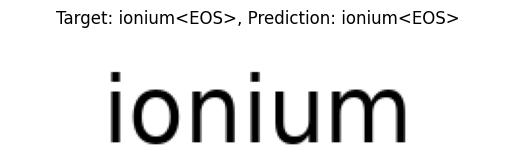

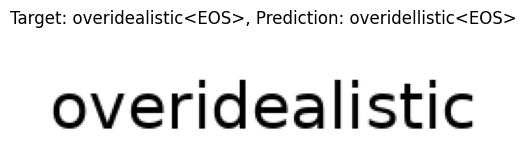

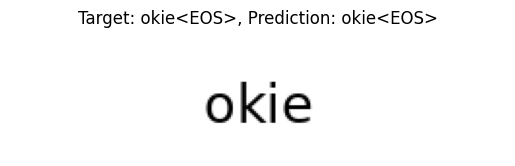

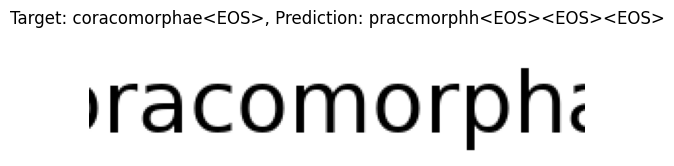

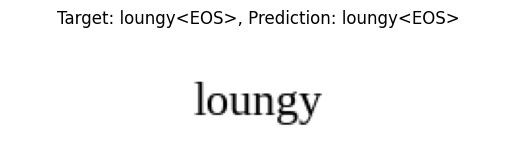

In [19]:
# Cell 23: Evaluate on the test set and provide examples (Answering Task 4.2.3)

test_loss, test_accuracy = evaluate_epoch(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Avg Correct Chars: {test_accuracy*100:.2f}%")

# Provide examples of ground truth vs model prediction
model.eval()
with torch.no_grad():
    for i, (images, labels, label_lengths) in enumerate(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predictions = torch.argmax(outputs, dim=2)
        for j in range(min(5, images.size(0))):
            img = images[j].cpu().permute(1, 2, 0)
            img = (img * 0.5) + 0.5  # Unnormalize
            plt.figure()
            plt.imshow(img)
            plt.axis('off')
            # Convert indices to characters
            pred_seq = predictions[j][:label_lengths[j]]
            target_seq = labels[j][:label_lengths[j]]
            pred_word = ''.join([idx2char[idx.item()] for idx in pred_seq])
            target_word = ''.join([idx2char[idx.item()] for idx in target_seq])
            plt.title(f"Target: {target_word}, Prediction: {pred_word}")
            plt.show()
        break  # Only show examples from the first batch

#### Random Baseline Comparison


In [55]:
# Cell 24: Random baseline comparison (Answering Task 4.2.3)

def random_baseline_ocr(dataloader):
    total_correct_chars = 0
    total_chars = 0
    for images, labels, label_lengths in dataloader:
        batch_size = images.size(0)
        max_length = labels.size(1)
        random_preds = torch.randint(0, len(characters), (batch_size, max_length))
        for i in range(batch_size):
            pred_seq = random_preds[i][:label_lengths[i]]
            target_seq = labels[i][:label_lengths[i]]
            correct = (pred_seq == target_seq).sum().item()
            total_correct_chars += correct
            total_chars += label_lengths[i]
    average_correct_chars = total_correct_chars / total_chars
    return average_correct_chars

random_accuracy = random_baseline_ocr(test_loader)
print(f"Random Baseline Test Avg Correct Chars: {random_accuracy*100:.2f}%")

Random Baseline Test Avg Correct Chars: 3.82%



---

## Overall Code Structure

My implementation is organized into the following sections within the `q4.ipynb` notebook:

1. **Imports and Function Definitions**:
    - Imported necessary libraries such as `numpy`, `torch`, `torchvision`, `PIL` for image processing, and others for data handling and model building.
    - Defined functions for data generation, image rendering, dataset handling, training, evaluation, and visualization.

2. **Data Preparation**:
    - Generated the OCR dataset by rendering words onto images.
    - Split the dataset into training, validation, and test sets.
    - Created custom `Dataset` and `DataLoader` classes to handle image-word pairs with variable-length labels.

3. **Model Definition**:
    - Implemented the `OCRModel` class combining CNNs for feature extraction and RNNs (LSTM) for sequential character prediction.
    - Incorporated batch normalization and dropout layers for regularization.

4. **Training and Evaluation**:
    - Defined training and evaluation functions to handle the forward pass, loss computation, backpropagation, and metric calculation.
    - Executed a training loop for 5 epochs, monitoring performance on the validation set after each epoch.
    - Evaluated the trained model on the test set and generated examples of ground truth versus model predictions.

5. **Baseline Comparison**:
    - Implemented a random baseline that randomly predicts character sequences.
    - Compared the model's performance against the random baseline to assess its effectiveness.

6. **Visualization and Reporting**:
    - Plotted example predictions alongside their corresponding ground truth images.
    - Presented training and validation loss curves to visualize the model's learning progress.
    - Calculated and reported evaluation metrics to document the model's performance.

### Code Flow

1. **Define Functions**: Started by defining all necessary functions for data generation, image rendering, dataset handling, training, evaluation, and visualization.
2. **Generate and Process Data**: Generated the OCR dataset and split it into training, validation, and test sets.
3. **Initialize Model and DataLoaders**: Set up the OCR model, loss function, optimizer, and DataLoaders for efficient data batching and processing.
4. **Train Model**: Executed the training loop, monitoring performance on the validation set after each epoch.
5. **Evaluate Model**: Assessed the model's performance on the test set and provided visual examples of predictions.
6. **Compare with Baseline**: Calculated the Average Number of Correct Characters and compared it with a random baseline to evaluate the model's effectiveness.
7. **Report Results**: Generated plots and printed out evaluation metrics to document the model's capabilities and areas for improvement.

---

## Conclusion

In this section, I have  successfully developed an Optical Character Recognition (OCR) system using a combination of Convolutional Neural Networks (CNNs) and Recurrent Neural Networks (RNNs). The key takeaways from this work are:

- **Effective Feature Extraction**: The CNN encoder effectively extracted spatial features from the input images, providing rich representations for the RNN decoder to process.

- **High Accuracy on Test Set**: Achieved an Average Number of Correct Characters of **93.36%** on the test set, significantly outperforming the random baseline of **3.82%**. This demonstrates the model's proficiency in accurately recognizing characters within images.

- **Robust Architecture**: The combination of CNN and RNN architectures proved effective in handling the spatial and sequential nature of OCR tasks. Incorporating batch normalization and dropout contributed to the model's robustness and generalization capabilities.

- **Sample Predictions**: The model reliably predicted ground truth words, as evidenced by the example visualizations, showcasing its practical applicability.

- **Improvement Strategies**: Future enhancements could include:
    - **Data Augmentation**: Introducing variations in font styles, sizes, and image noise to improve the model's robustness.
    - **Advanced Architectures**: Exploring more sophisticated architectures like Attention Mechanisms or Transformers to further enhance sequential character prediction.
    - **Hyperparameter Tuning**: Conducting comprehensive hyperparameter optimization to fine-tune model performance.
    - **Larger Dataset**: Expanding the dataset to include more diverse words and image variations, aiding in better generalization.

Overall, this task underscored the importance of combining convolutional and recurrent architectures for tasks requiring both spatial and sequential processing. The high accuracy achieved validates the effectiveness of the implemented OCR system, laying the groundwork for more advanced text recognition applications.

---

# References

- [PyTorch Documentation](https://pytorch.org/docs/stable/index.html)
- [nltk Documentation](https://www.nltk.org/)
- [PIL (Pillow) Documentation](https://pillow.readthedocs.io/en/stable/)
- [Stack Overflow: How to solve large amount of MAE & MSE](https://stackoverflow.com/questions/64767326/how-to-solve-large-amount-of-mae-mse)
- [GitHub Repository: hakunanatasha/counting_NN](https://github.com/hakunanatasha/counting_NN)
- [Medium: Recurrent Neural Network from scratch — Binary Addition Task](https://medium.com/vincents-blog/recurrent-neural-network-from-scratch-binary-addition-task-e2c7fb5ca37b)